## RSNA First Run

Original Kernel: https://www.kaggle.com/radek1/fastai-starter-pack-train-basic-model-and-submit

In [1]:
import os
os.environ['DEFAULT_GPU'] = '4'

In [2]:
from fastai2.data.all import *
from fastai2.tabular.core import *
from fastai2.optimizer import *
from fastai2.learner import *
from fastai2.metrics import *
from fastai2.callback.all import *

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import lightgbm as lgbm

In [4]:
data_path = Path('~/data/rsna/').expanduser()
local_data_path = Path('/mnt/data0/home/ashaw/local_data/rsna/')

## Labelling

In [5]:
pivot_path = local_data_path/'train_pivot.csv'
label_df = pd.read_csv(pivot_path)
label_df.set_index('fn', inplace=True)
label_df

,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
fn,,,,,,
ID_000039fa0,0,0,0,0,0,0
ID_00005679d,0,0,0,0,0,0
ID_00008ce3c,0,0,0,0,0,0
ID_0000950d7,0,0,0,0,0,0
ID_0000aee4b,0,0,0,0,0,0
...,...,...,...,...,...,...
ID_ffff73ede,0,0,0,0,0,0
ID_ffff80705,0,0,0,0,0,0
ID_ffff82e46,0,0,0,0,0,0


## Tabular

In [6]:
df_trn_proc = pd.read_feather(local_data_path/'df_trn_proc.fth')
df_trn_proc.set_index('fname', inplace=True)

## RandomForest Classifier

In [7]:
df_trn_proc.head()

,BitsStored,Columns,HighBit,MultiWindow,PixelRepresentation,RescaleIntercept,RescaleSlope,Rows,WindowCenter,WindowCenter1,...,img_max_na,ImagePositionPatient2_na,ImageOrientationPatient0_na,ImageOrientationPatient4_na,PixelSpacing1_na,img_min_na,img_mean_na,ImageOrientationPatient5_na,WindowCenter1_na,ImageOrientationPatient3_na
fname,,,,,,,,,,,,,,,,,,,,,
ID_352e89f1c,2,7,2,1,2,1,1,6,-0.294942,-0.799350,...,1,1,1,1,1,1,1,1,1,1
ID_3cf4fb50f,1,7,1,2,1,1,1,6,-0.001099,0.735059,...,1,1,1,1,1,1,1,1,1,1
ID_2a8702d25,2,7,2,1,2,1,1,6,-0.050073,-0.799350,...,1,1,1,1,1,1,1,1,1,1
ID_66891ac22,2,7,2,1,2,1,1,6,-0.294942,-0.799350,...,1,1,1,1,1,1,1,1,1,1
ID_54f412d54,1,7,1,2,1,1,1,6,-0.001099,0.735059,...,1,1,1,1,1,1,1,1,1,1


In [8]:
label_df.head()

,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
fn,,,,,,
ID_000039fa0,0,0,0,0,0,0
ID_00005679d,0,0,0,0,0,0
ID_00008ce3c,0,0,0,0,0,0
ID_0000950d7,0,0,0,0,0,0
ID_0000aee4b,0,0,0,0,0,0


In [9]:
label_df.loc['ID_2a8702d25']

any                 1
epidural            0
intraparenchymal    1
intraventricular    1
subarachnoid        0
subdural            0
Name: ID_2a8702d25, dtype: int64

In [10]:
joined_df = df_trn_proc.join(label_df)

In [11]:
joined_df.head()

,BitsStored,Columns,HighBit,MultiWindow,PixelRepresentation,RescaleIntercept,RescaleSlope,Rows,WindowCenter,WindowCenter1,...,img_mean_na,ImageOrientationPatient5_na,WindowCenter1_na,ImageOrientationPatient3_na,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
fname,,,,,,,,,,,,,,,,,,,,,
ID_352e89f1c,2,7,2,1,2,1,1,6,-0.294942,-0.799350,...,1,1,1,1,0,0,0,0,0,0
ID_3cf4fb50f,1,7,1,2,1,1,1,6,-0.001099,0.735059,...,1,1,1,1,0,0,0,0,0,0
ID_2a8702d25,2,7,2,1,2,1,1,6,-0.050073,-0.799350,...,1,1,1,1,1,0,1,1,0,0
ID_66891ac22,2,7,2,1,2,1,1,6,-0.294942,-0.799350,...,1,1,1,1,1,0,1,0,0,0
ID_54f412d54,1,7,1,2,1,1,1,6,-0.001099,0.735059,...,1,1,1,1,0,0,0,0,0,0


In [12]:
df_x = pd.DataFrame(joined_df, columns=joined_df.columns[:-6])
df_y = pd.DataFrame(joined_df, columns=joined_df.columns[-6:])

In [13]:
trn_x, tst_x, trn_y, tst_y = train_test_split(df_x, df_y, test_size=0.1)

In [14]:
rf = RandomForestClassifier(n_jobs=8)

In [ ]:
rf.fit(trn_x, trn_y)

In [ ]:
rf.score(tst_x, tst_y)

In [ ]:
feature_importances = pd.DataFrame(
    rf.feature_importances_, index = trn_x.columns,
    columns=['importance']).sort_values('importance', ascending=False)

In [ ]:
feature_importances

## Feature Importance - Test/Val split by PatientID

In [22]:
df_trn_all = pd.read_feather(data_path/'df_trn.fth')
df_trn_all['fname'] = df_trn_all['fname'].str.replace(r'.dcm$', '')
df_trn_all.set_index('fname', inplace=True)

In [23]:
df_trn_proc = pd.read_feather(local_data_path/'df_trn_proc.fth')
df_trn_proc.set_index('fname', inplace=True)

In [24]:
df_pid = pd.DataFrame(df_trn_all.PatientID)

In [25]:
joined_df = df_pid.join(df_trn_proc.join(label_df))

## Split 50:50 on labels

In [17]:
df_lbl = joined_df.query('any==True')
n_lbl = len(df_lbl); n_lbl

97103

In [27]:
df_nonlbl = joined_df.query('any==False').sample(n_lbl)
len(df_nonlbl)

97103

In [28]:
joined_df = pd.concat([df_lbl,df_nonlbl])
len(joined_df)

194206

## Split by patients

In [29]:
len(Counter(joined_df.PatientID.values))

17060

In [30]:
pids = list(set(joined_df.PatientID.values))
idxs = RandomSplitter(valid_pct=0.1)(pids)

In [31]:
trn_pids = [pids[i] for i in idxs[0]]
tst_pids = [pids[i] for i in idxs[1]]
len(trn_pids), len(tst_pids)

(15354, 1706)

In [32]:
df_trn = joined_df.loc[joined_df.PatientID.isin(trn_pids)].drop(columns='PatientID')
df_tst = joined_df.loc[joined_df.PatientID.isin(tst_pids)].drop(columns='PatientID')

In [33]:
df_trn.shape, df_tst.shape

((174784, 52), (19422, 52))

## Split by x,y

In [34]:
trn_x = pd.DataFrame(df_trn, columns=df_trn.columns[:-6])
trn_y = pd.DataFrame(df_trn, columns=df_trn.columns[-6:])

In [35]:
tst_x = pd.DataFrame(df_tst, columns=df_tst.columns[:-6])
tst_y = pd.DataFrame(df_tst, columns=df_tst.columns[-6:])

In [37]:
trn_x

,BitsStored,Columns,HighBit,MultiWindow,PixelRepresentation,RescaleIntercept,RescaleSlope,Rows,WindowCenter,WindowCenter1,...,img_max_na,ImagePositionPatient2_na,ImageOrientationPatient0_na,ImageOrientationPatient4_na,PixelSpacing1_na,img_min_na,img_mean_na,ImageOrientationPatient5_na,WindowCenter1_na,ImageOrientationPatient3_na
fname,,,,,,,,,,,,,,,,,,,,,
ID_2a8702d25,2,7,2,1,2,1,1,6,-0.050073,-0.799350,...,1,1,1,1,1,1,1,1,1,1
ID_66891ac22,2,7,2,1,2,1,1,6,-0.294942,-0.799350,...,1,1,1,1,1,1,1,1,1,1
ID_8e6e5b51f,2,7,2,1,2,1,1,6,-0.294942,-0.799350,...,1,1,1,1,1,1,1,1,1,1
ID_390e0dfbb,2,7,2,1,2,1,1,6,0.194796,-0.799350,...,1,1,1,1,1,1,1,1,1,1
ID_1bb6286d2,2,7,2,1,2,1,1,6,-0.294942,-0.799350,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID_efb23bc01,2,7,2,1,2,1,1,6,-0.294942,-0.799350,...,1,1,1,1,1,1,1,1,1,1
ID_4945e611c,1,7,1,2,1,1,1,6,0.194796,0.905549,...,1,1,1,1,1,1,1,1,1,1
ID_2dcd3b242,1,7,1,2,1,1,1,6,-0.001099,0.735059,...,1,1,1,1,1,1,1,1,1,1


## Classify

In [36]:
rf = RandomForestClassifier(min_samples_leaf=4, min_samples_split=2, n_jobs=8)

In [38]:
rf.fit(trn_x, trn_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=8,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [40]:
feature_importances = pd.DataFrame(
    rf.feature_importances_, index = trn_x.columns,
    columns=['importance']).sort_values('importance', ascending=False)

In [42]:
feature_importances

,importance
img_mean,0.138032
img_std,0.136919
ImagePositionPatient2,0.118163
ImagePositionPatient1,0.107537
img_max,0.098542
WindowCenter,0.064309
ImageOrientationPatient5,0.049482
ImageOrientationPatient4,0.048455
WindowWidth,0.041391
ImagePositionPatient0,0.040586


## Test Score

In [39]:
rf.score(tst_x, tst_y)

0.4614354855318711

## Permutation importance

In [41]:
from sklearn.inspection import permutation_importance

In [44]:
result = permutation_importance(rf, tst_x, tst_y, n_repeats=2,
                                random_state=42, n_jobs=1)

In [45]:
sorted_idx = result.importances_mean.argsort()

In [46]:
feature_importances = pd.DataFrame(
    result.importances_mean, index = tst_x.columns,
    columns=['importance']).sort_values('importance', ascending=False)

In [47]:
feature_importances

,importance
WindowCenter,0.051076
ImagePositionPatient1,0.028241
WindowCenter1,0.026851
ImagePositionPatient2,0.023221
PixelSpacing1,0.013670
img_max,0.013413
PixelSpacing0,0.011945
img_mean,0.011302
img_min,0.009886
ImageOrientationPatient4,0.008933


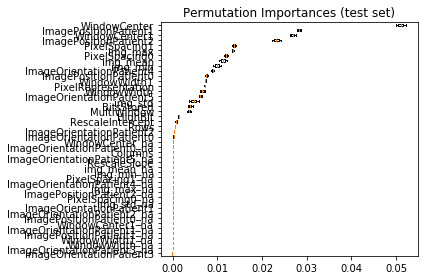

In [48]:
fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=tst_x.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

## CSV